In [1]:
import numpy as np
#import matplotlib
#matplotlib.use('Agg');
import matplotlib.pyplot as plt
#plt.set_cmap('jet');
import random
import os
import sys
import pickle
import pandas as pd
import argparse
from textwrap import wrap
%matplotlib inline
import seaborn as sns
from copy import copy
from glob import glob
from skimage import io

import warnings
warnings.filterwarnings("ignore")

In [2]:
# GLOBALS
EPOCH=499
SEEDS=[1234, 3232, 3221, 9856, 1290, 
       1987, 3200, 6400, 8888, 451]

In [3]:
# FUNCTIONS TO DEPRECATE
def plot_curves(df, mode='test'):
    """Plots the test AUC over epochs for an experiment table."""
    
    import warnings
    raise warnings.DeprecationWarning("Not using this anymore, using Seaborn Plotting tools instead!")    
    
    EPOCH = 499
    EXPERIMENTS = ['unet', 'ae', 'resnet', 'cnn']
    EXP_NAMES = ["UNet", "Autoencoder", "ResNet 18", "ConvNet"]

    assert mode in ['test', 'train', 'valid']
    
    fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)
    ax = ax.ravel()
    
    for i, (exp, exp_name) in enumerate(zip(EXPERIMENTS, EXP_NAMES)):
        
        ls = ['solid', 'dashed', 'dashdot', 'dotted', '-' ,'--' ,'-.' , ':','None' ,' ' ,'' ]
        dfs = df.reindex()

        # Filter by experiment.
        dfs = dfs[dfs['experiment_name'].str.contains(exp)]

        for j, name in enumerate(sorted(dfs.experiment_name.unique())):
 
            thisdata = dfs[dfs["experiment_name"] == name]
            willplot = thisdata.groupby(["epoch"]).mean()
            r = willplot.plot(y="{}_auc".format(mode), 
                              ax=ax[i], label=name, ls=ls[j])

        patches, labels = ax[i].get_legend_handles_labels()
 
        ax[i].legend(patches, labels, loc='lower right', title="experiment")    
        ax[i].set_ylim(-0.05, 1.05)  
        ax[i].set_ylabel("AUC")  
        ax[i].set_xlabel("Epoch")

        ax[i].set_title("{} Experiments".format(exp_name))
        fig.set_tight_layout(tight=True)
        

In [4]:
# FUNCTIONS IN USE
def get_metrics(path):
    """Loads the outputs of training."""
    all_df = [] 
    for f in glob(os.path.join(path, "*/stats/metrics.pkl")):
        d = pickle.load(open(f,"rb"))
        all_df.append(pd.DataFrame.from_dict(d))

    return(all_df)


def df_cleaner(df):
    """Selects the columns of the metrics dataframe to keep."""
    KEEP = ["auc", "best", "seed", "recon_lambda", "actdiff_lambda", 
            "gradmask_lambda", "epoch", "name", "maxmasks", 'optimizer_lr']
    for col in df.columns:
        if not any([string in col for string in KEEP]):
            del df[col]

    # Experiment name is determined by the configuration file used.
    experiments = df.experiment_name.unique()

    print("resulting df \nshape={} tracking {} experiments, \ncolumns={}".format(
        df.shape, len(experiments), df.columns))
    return(df)


def get_last_results_at_epoch(df, epoch, sig_digits=3):
    """Get the train/test/valid AUC at the final, not best, epoch."""
    #groups = ['experiment_name', 'actdiff_lambda', 'recon_lambda']
    fmt_str = "${0:." + str(sig_digits) + "f}\pm{1:." + str(sig_digits) + "f}$"
    
    groups = ['experiment_name']
    cols = ['train_auc', 'valid_auc', 'best_epoch']
    
    df = get_results_at_epoch(df, epoch, groups, cols)
    df = df.round(sig_digits)
    
    results = [] 
    for a, b in zip(df["train_auc"], df["train_auc_std"]):
        results.append(fmt_str.format(a, b))
    df['train_auc'] = results 
    df = df.drop(['train_auc_std'], axis=1)

    results = [] 
    for a, b in zip(df["valid_auc"], df["valid_auc_std"]):
        results.append(fmt_str.format(a, b))
    df['valid_auc'] = results 
    df = df.drop(['valid_auc_std'], axis=1)
    
    results = [] 
    for a, b in zip(df["best_epoch"], df["best_epoch_std"]):
        results.append(fmt_str.format(a, b))
    df['best_epoch'] = results 
    df = df.drop(['best_epoch_std'], axis=1)
    
    return df


def get_all_best_results_at_epoch(dfs, epoch, sig_digits=3, count=False):
    """
    Merge the best test results for all dataframes submitted. 
    Used to make a results table across datasets.
    """
    
    fmt_str = "${0:." + str(sig_digits) + "f}\pm{1:." + str(sig_digits) + "f}$"
    for i, df in enumerate(dfs):
        tmp_df = copy(df)
        
        # Strip the dataset name out of the experiment name.        
        name = tmp_df['experiment_name'].iloc[0].split('_')[0]
        tmp_df['experiment_name'] = tmp_df['experiment_name'].str.replace('{}_'.format(name), '')
        
        # Reformat the table.
        tmp_df = get_best_results_at_epoch(tmp_df, epoch, count=count)
        tmp_df = tmp_df.round(sig_digits)

        # Merge mean+/-std into a single column with the experiment name.
        results = [] 
        for a, b in zip(tmp_df["best_test_auc"], tmp_df["best_test_auc_std"]):
            results.append(fmt_str.format(a, b))
        tmp_df['test_auc_{}'.format(name)] = results 
        tmp_df = tmp_df.drop(['best_test_auc', 'best_test_auc_std'], axis=1)

        # Merge the experiments.
        if i == 0:
            final_df = copy(tmp_df)
        else:
            final_df = pd.merge(final_df, tmp_df, on='experiment_name')
    
    return final_df


def get_results_at_epoch(df, epoch, groups, cols, count=False, mode='mean'):
    """
    Shows a reduced form of the table with mean and std values 
    over experiments.
    """
    df_tmp = df[(df.epoch==epoch)].groupby(groups)[cols]
    if mode == 'mean':
        df = df_tmp.mean().join(df_tmp.std(),rsuffix='_std')
    elif mode == 'max':
        df = df_tmp.max().join(df_tmp.std(),rsuffix='_std')
    if count:
        df = df.join(df_tmp.count(), rsuffix='_count')
                                                                        
    return df


def get_best_results_at_epoch(df, epoch, count=False):
    """Get the test results at the best epoch."""
    groups = ['experiment_name']
    cols = ['best_test_auc']
    
    return get_results_at_epoch(df, epoch, groups, cols, count=count, mode='mean')


def get_search_results_at_epoch(df, epoch):
    """Get the test results at the best epoch."""
    cols = ['experiment_name', 'best_valid_auc', 'optimizer_lr']
    groups = ['experiment_name', 'optimizer_lr']
    
    return get_results_at_epoch(df, epoch, groups, cols, mode='max')


def get_mask_results_at_epoch(df, epoch):
    """
    Get the results of the maxmask experiments at a given epoch. Not used currently.
    """
    groups = ["experiment_name", "epoch", "train_dataset_maxmasks"]
    cols = ["best_test_auc", "best_epoch"]
    
    return get_results_at_epoch(df, epoch, groups, cols)


def get_lineplot_df(input_df, epoch):
    """
    Gets a dataframe useful for the lineplots below.
    """
    df = copy(input_df)
    df = df[(df.epoch==EPOCH)]
    idx = ~df['experiment_name'].str.contains('cnn')
    df = df[idx]
    idx = ~df['experiment_name'].str.contains('_ae_')
    return df[idx]


def get_curveplot_df(input_df, mode):
    """
    Gets a dataframe useful for the curveplots below.
    """
    df = copy(input_df)
    idx = df['experiment_name'].str.contains(mode)
    return df[idx]


def read_img(exp):
    """Reads best epoch images that are generated by the training loop."""
    file = glob("../images/{}/image-best_valid-*.png".format(exp))
    image = io.imread(file[0])
    plt.imshow(image)
    plt.show();
    
def merge_dfs_for_maxmasks(df, df_mask, old_prefix, new_prefix, actdiff_lamb):
    tmp_resnet_act = df[df['experiment_name'] == '{}_resnet'.format(old_prefix)]
    tmp_resnet_act['experiment_name'] = '{}_resnet_actdiff'.format(new_prefix)
    tmp_resnet_act['maxmasks_train'] = 0
    tmp_resnet_act['actdiff_lambda'] = actdiff_lamb
    tmp_resnet_grd = df[df['experiment_name'] == '{}_resnet'.format(old_prefix)]
    tmp_resnet_grd['experiment_name'] = '{}_resnet_gradmask'.format(new_prefix)
    tmp_resnet_grd['maxmasks_train'] = 0
    tmp_resnet_grd['actdiff_lambda'] = 0
    tmp_unet_act = df[df['experiment_name'] == '{}_unet'.format(old_prefix)]
    tmp_unet_act['experiment_name'] = '{}_unet_actdiff'.format(new_prefix)
    tmp_unet_act['maxmasks_train'] = 0
    tmp_unet_act['actdiff_lambda'] = actdiff_lamb
    tmp_unet_grd = df[df['experiment_name'] == '{}_unet'.format(old_prefix)]
    tmp_unet_grd['experiment_name'] = '{}_unet_gradmask'.format(new_prefix)
    tmp_unet_grd['maxmasks_train'] = 0
    tmp_unet_grd['actdiff_lambda'] = 0
    df_mask = pd.concat([df_mask, tmp_resnet_act, tmp_resnet_grd, tmp_unet_act, tmp_unet_grd])
    
    return df_mask


def seed_finder(df, experiment_name):
    test = df[df.epoch == EPOCH]
    test = test[test['experiment_name'] == experiment_name]

    for seed in SEEDS:
        if seed not in np.array(test['seed']):
            print("{} missing {}".format(experiment_name, seed))

In [5]:
# Collects all of the results available in logs-single (for individual runs)                    
df = pd.concat(get_metrics("../logs-single"))
df = df_cleaner(df)

# Collect the MSDDataset experiments.
df_synth = df[df['experiment_name'].str.contains('synth_')]
df_liver = df[df['experiment_name'].str.contains('livermsd_')]
df_cardiac = df[df['experiment_name'].str.contains('cardiacmsd_')]
df_pancreas = df[df['experiment_name'].str.contains('pancreasmsd_')]
df_baseline = pd.concat([df_synth, df_liver, df_cardiac, df_pancreas], axis=0)

resulting df 
shape=(944000, 17) tracking 120 experiments, 
columns=Index(['actdiff_lambda', 'best_epoch', 'best_test_auc', 'best_train_auc',
       'best_valid_auc', 'epoch', 'experiment_name', 'gradmask_lambda',
       'maxmasks_train', 'num_epochs', 'optimizer_lr', 'recon_lambda', 'seed',
       'test_auc', 'train_auc', 'train_dataset_maxmasks', 'valid_auc'],
      dtype='object')


In [6]:
# Ugly thing for figuring out if you have all the seeds.
seed_finder(df_baseline, 'livermsd_unet')

In [6]:
# Uses the control experiments (no activmask) as the "maxmasks=0" runs for the maxmasks plots below.
df_synth_mask = df[df['experiment_name'].str.contains('synth-masks')]
df_synth_mask = merge_dfs_for_maxmasks(df_synth, df_synth_mask, 'synth', 'synth-masks', 10)
df_liver_mask = df[df['experiment_name'].str.contains('livermsd-masks')]
df_liver_mask = merge_dfs_for_maxmasks(df_liver, df_liver_mask, 'livermsd', 'livermsd-masks', 1)
df_cardiac_mask = df[df['experiment_name'].str.contains('cardiacmsd-masks')]
df_cardiac_mask = merge_dfs_for_maxmasks(df_cardiac, df_cardiac_mask, 'cardiacmsd', 'cardiacmsd-masks', 1)
df_pancreas_mask = df[df['experiment_name'].str.contains('pancreasmsd-masks')]
df_pancreas_mask = merge_dfs_for_maxmasks(df_pancreas, df_pancreas_mask, 'pancreasmsd', 'pancreasmsd-masks', 1)
df_mask = pd.concat([df_synth_mask, df_liver_mask, df_cardiac_mask, df_pancreas_mask], axis=0)

In [4]:
# Ugly baseline manual search stuff...
#
#df_skopt = pd.concat(get_metrics("../logs"))
#df_skopt = df_cleaner(df_skopt)
#
#df_cardiac_search = df[df['experiment_name'].str.contains('cardiacmsd-search')]
#df_pancreas_search = df[df['experiment_name'].str.contains('pancreasmsd-search')]
#df_liver_search = df[df['experiment_name'].str.contains('livermsd-search')]
#df_baseline_search = df_skopt[df_skopt['experiment_name'].str.contains('resnet_baseline')]

In [14]:
# Dumb gridsearch results.
#get_search_results_at_epoch(df_cardiac_search, EPOCH)

best_valid_auc  \
experiment_name                      optimizer_lr                   
cardiacmsd-search_resnet_actdiff_16  0.0001              0.949219   
                                     0.0010              0.957031   
                                     0.0100              0.964844   
cardiacmsd-search_resnet_actdiff_32  0.0001              0.949219   
                                     0.0010              0.941406   
                                     0.0100              0.964844   
cardiacmsd-search_resnet_actdiff_4   0.0001              0.957031   
                                     0.0010              0.960938   
                                     0.0100              0.949219   
cardiacmsd-search_resnet_actdiff_8   0.0001              0.960938   
                                     0.0010              0.957031   
                                     0.0100              0.953125   
cardiacmsd-search_resnet_gradmask_16 0.0001              0.957031   
                                     0.0010              0.953125   
                                     0.0100              0.949219   
cardiacmsd-search_resnet_gradmask_32 0.0001              0.953125   
                                     0.0010              0.960938   
                                     0.0100              0.957031   
cardiacmsd-search_resnet_gradmask_4  0.0001              0.949219   
                                     0.0010              0.953125   
                                     0.0100              0.937500   
cardiacmsd-search_resnet_gradmask_8  0.0001              0.960938   
                                     0.0010              0.957031   
                                     0.0100              0.945312   

                                                   best_valid_auc_std  \
experiment_name                      optimizer_lr                       
cardiacmsd-search_resnet_actdiff_16  0.0001                       NaN   
                                     0.0010                       NaN   
                                     0.0100                       NaN   
cardiacmsd-search_resnet_actdiff_32  0.0001                       NaN   
                                     0.0010                       NaN   
                                     0.0100                       NaN   
cardiacmsd-search_resnet_actdiff_4   0.0001                       NaN   
                                     0.0010                       NaN   
                                     0.0100                       NaN   
cardiacmsd-search_resnet_actdiff_8   0.0001                       NaN   
                                     0.0010                       NaN   
                                     0.0100                       NaN   
cardiacmsd-search_resnet_gradmask_16 0.0001                       NaN   
                                     0.0010                       NaN   
                                     0.0100                       NaN   
cardiacmsd-search_resnet_gradmask_32 0.0001                       NaN   
                                     0.0010                       NaN   
                                     0.0100                       NaN   
cardiacmsd-search_resnet_gradmask_4  0.0001                       NaN   
                                     0.0010                       NaN   
                                     0.0100                       NaN   
cardiacmsd-search_resnet_gradmask_8  0.0001                       NaN   
                                     0.0010                       NaN   
                                     0.0100                       NaN   

                                                   optimizer_lr  
experiment_name                      optimizer_lr                
cardiacmsd-search_resnet_actdiff_16  0.0001                 NaN  
                                     0.0010                 NaN  
                                     0.0100                 NaN  
cardiacmsd-search_resnet_ac

In [15]:
#get_search_results_at_epoch(df_pancreas_search, EPOCH)

best_valid_auc  \
experiment_name                       optimizer_lr                   
pancreasmsd-search_resnet_actdiff_16  0.0001              0.882812   
                                      0.0010              0.863281   
                                      0.0100              0.867188   
pancreasmsd-search_resnet_actdiff_32  0.0001              0.890625   
                                      0.0100              0.855469   
pancreasmsd-search_resnet_actdiff_4   0.0001              0.878906   
                                      0.0010              0.871094   
                                      0.0100              0.855469   
pancreasmsd-search_resnet_actdiff_8   0.0001              0.867188   
                                      0.0010              0.875000   
                                      0.0100              0.582031   
pancreasmsd-search_resnet_gradmask_16 0.0001              0.902344   
                                      0.0010              0.886719   
                                      0.0100              0.812500   
pancreasmsd-search_resnet_gradmask_32 0.0001              0.890625   
                                      0.0010              0.894531   
                                      0.0100              0.886719   
pancreasmsd-search_resnet_gradmask_4  0.0001              0.886719   
                                      0.0010              0.855469   
                                      0.0100              0.796875   
pancreasmsd-search_resnet_gradmask_8  0.0001              0.890625   
                                      0.0010              0.894531   
                                      0.0100              0.816406   

                                                    best_valid_auc_std  \
experiment_name                       optimizer_lr                       
pancreasmsd-search_resnet_actdiff_16  0.0001                       NaN   
                                      0.0010                       NaN   
                                      0.0100                       NaN   
pancreasmsd-search_resnet_actdiff_32  0.0001                       NaN   
                                      0.0100                       NaN   
pancreasmsd-search_resnet_actdiff_4   0.0001                       NaN   
                                      0.0010                       NaN   
                                      0.0100                       NaN   
pancreasmsd-search_resnet_actdiff_8   0.0001                       NaN   
                                      0.0010                       NaN   
                                      0.0100                       NaN   
pancreasmsd-search_resnet_gradmask_16 0.0001                       NaN   
                                      0.0010                       NaN   
                                      0.0100                       NaN   
pancreasmsd-search_resnet_gradmask_32 0.0001                       NaN   
                                      0.0010                       0.0   
                                      0.0100                       NaN   
pancreasmsd-search_resnet_gradmask_4  0.0001                       NaN   
                                      0.0010                       NaN   
                                      0.0100                       NaN   
pancreasmsd-search_resnet_gradmask_8  0.0001                       NaN   
                                      0.0010                       NaN   
                                      0.0100                       NaN   

                                                    optimizer_lr  
experiment_name                       optimizer_lr                
pancreasmsd-search_resnet_actdiff_16  0.0001                 NaN  
                                      0.0010                 NaN  
                                      0.0100                 NaN  
pancreasmsd-search_resnet_actdiff_32  0.0001                 NaN  
                                      0.0100    

In [16]:
#get_search_results_at_epoch(df_liver_search, EPOCH)

best_valid_auc  \
experiment_name                    optimizer_lr                   
livermsd-search_resnet_actdiff_16  0.0001              0.957031   
                                   0.0010              0.933594   
                                   0.0100              0.945312   
livermsd-search_resnet_actdiff_32  0.0001              0.957031   
                                   0.0010              0.945312   
                                   0.0100              0.933594   
livermsd-search_resnet_actdiff_4   0.0001              0.953125   
                                   0.0010              0.937500   
                                   0.0100              0.921875   
livermsd-search_resnet_actdiff_8   0.0001              0.957031   
                                   0.0010              0.941406   
                                   0.0100              0.941406   
livermsd-search_resnet_gradmask_16 0.0001              0.972656   
                                   0.0010              0.964844   
                                   0.0100              0.949219   
livermsd-search_resnet_gradmask_32 0.0001              0.964844   
                                   0.0010              0.953125   
                                   0.0100              0.957031   
livermsd-search_resnet_gradmask_4  0.0001              0.964844   
                                   0.0010              0.957031   
                                   0.0100              0.957031   
livermsd-search_resnet_gradmask_8  0.0001              0.964844   
                                   0.0010              0.960938   
                                   0.0100              0.949219   

                                                 best_valid_auc_std  \
experiment_name                    optimizer_lr                       
livermsd-search_resnet_actdiff_16  0.0001                       NaN   
                                   0.0010                       NaN   
                                   0.0100                       NaN   
livermsd-search_resnet_actdiff_32  0.0001                       NaN   
                                   0.0010                       NaN   
                                   0.0100                       NaN   
livermsd-search_resnet_actdiff_4   0.0001                       NaN   
                                   0.0010                       NaN   
                                   0.0100                       NaN   
livermsd-search_resnet_actdiff_8   0.0001                       NaN   
                                   0.0010                       NaN   
                                   0.0100                       NaN   
livermsd-search_resnet_gradmask_16 0.0001                       NaN   
                                   0.0010                       NaN   
                                   0.0100                       NaN   
livermsd-search_resnet_gradmask_32 0.0001                       NaN   
                                   0.0010                       NaN   
                                   0.0100                       NaN   
livermsd-search_resnet_gradmask_4  0.0001                       NaN   
                                   0.0010                       NaN   
                                   0.0100                       NaN   
livermsd-search_resnet_gradmask_8  0.0001                       NaN   
                                   0.0010                       NaN   
                                   0.0100                       NaN   

                                                 optimizer_lr  
experiment_name                    optimizer_lr                
livermsd-search_resnet_actdiff_16  0.0001                 NaN  
                                   0.0010                 NaN  
                                   0.0100                 NaN  
livermsd-search_resnet_actdiff_32  0.0001                 NaN  
                                   0.0010                 NaN  
           

In [8]:
#df_baseline_search[(df_baseline_search.epoch==99)]

,actdiff_lambda,best_epoch,best_test_auc,best_train_auc,best_valid_auc,epoch,experiment_name,gradmask_lambda,maxmasks_train,num_epochs,optimizer_lr,recon_lambda,test_auc,train_auc,train_dataset_maxmasks,valid_auc
99,0,21,0.863281,0.992188,0.937500,99,livermsd_resnet_baseline-search,0,1,100,0.0001,0,0.863281,1.00000,1,0.917969
99,0,93,0.898438,0.984375,0.953125,99,cardiacmsd_resnet_baseline-search,0,1,100,0.0043,0,0.898438,0.90625,1,0.871094
99,0,85,0.812500,0.968750,0.902344,99,pancreasmsd_resnet_baseline-search,0,1,100,0.0001,0,0.812500,1.00000,1,0.855469


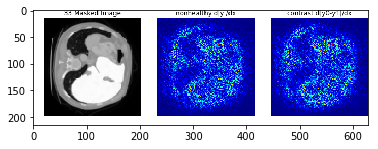

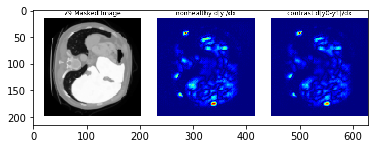

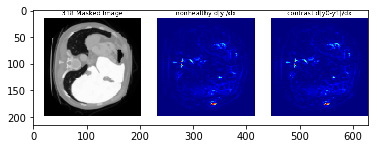

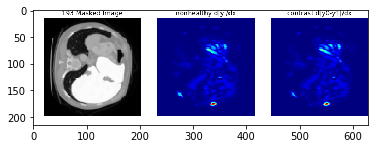

In [9]:
# Shows simple "best epoch" images.
read_img("livermsd_resnet")
read_img("livermsd_resnet_actdiff")
read_img("livermsd_resnet_gradmask")
read_img("livermsd_resnet_actgrad")

In [10]:
# Write table showing the results at the final epoch.
with open('tables/synth_last_results.tex','w') as tf:
    tf.write(get_last_results_at_epoch(df_synth, EPOCH, sig_digits=2).to_latex())

get_last_results_at_epoch(df_synth, EPOCH, sig_digits=2)

,train_auc,valid_auc,best_epoch
experiment_name,,,
synth_ae,$1.00\pm0.00$,$0.06\pm0.03$,$0.00\pm0.00$
synth_ae_actdiff,$0.80\pm0.26$,$0.80\pm0.26$,$140.10\pm156.84$
synth_ae_actgrad,$0.50\pm0.00$,$0.50\pm0.00$,$0.00\pm0.00$
synth_ae_clfmasked,$1.00\pm0.00$,$0.53\pm0.01$,$127.00\pm132.24$
synth_ae_gradmask,$0.50\pm0.00$,$0.50\pm0.00$,$44.70\pm102.68$
synth_ae_reconmasked,$1.00\pm0.00$,$0.06\pm0.05$,$0.00\pm0.00$
synth_cnn,$1.00\pm0.00$,$0.00\pm0.01$,$38.10\pm120.13$
synth_cnn_actdiff,$0.50\pm0.00$,$0.50\pm0.00$,$7.30\pm23.08$
synth_cnn_actgrad,$0.50\pm0.00$,$0.50\pm0.00$,$0.00\pm0.00$


In [11]:
# Write table showing best test AUC results.
with open('tables/all_test_results.tex', 'w') as tf:
    tf.write(get_all_best_results_at_epoch([df_synth, df_liver, df_cardiac, df_pancreas], EPOCH, sig_digits=2).to_latex())

get_all_best_results_at_epoch([df_synth, df_liver, df_cardiac, df_pancreas], EPOCH, sig_digits=2)

,test_auc_synth,test_auc_livermsd,test_auc_cardiacmsd,test_auc_pancreasmsd
experiment_name,,,,
ae,$0.50\pm0.00$,$0.78\pm0.10$,$0.76\pm0.17$,$0.77\pm0.01$
ae_actdiff,$0.78\pm0.24$,$0.80\pm0.02$,$0.84\pm0.08$,$0.76\pm0.02$
ae_actgrad,$0.50\pm0.00$,$0.82\pm0.01$,$0.69\pm0.17$,$0.78\pm0.02$
ae_clfmasked,$0.79\pm0.11$,$0.59\pm0.05$,$0.69\pm0.10$,$0.51\pm0.03$
ae_gradmask,$0.52\pm0.05$,$0.75\pm0.09$,$0.89\pm0.10$,$0.77\pm0.02$
ae_reconmasked,$0.50\pm0.00$,$0.84\pm0.02$,$0.82\pm0.17$,$0.81\pm0.02$
cnn,$0.35\pm0.20$,$0.87\pm0.02$,$0.86\pm0.13$,$0.82\pm0.02$
cnn_actdiff,$0.50\pm0.00$,$0.77\pm0.12$,$0.60\pm0.11$,$0.66\pm0.12$
cnn_actgrad,$0.50\pm0.00$,$0.79\pm0.10$,$0.50\pm0.00$,$0.66\pm0.05$


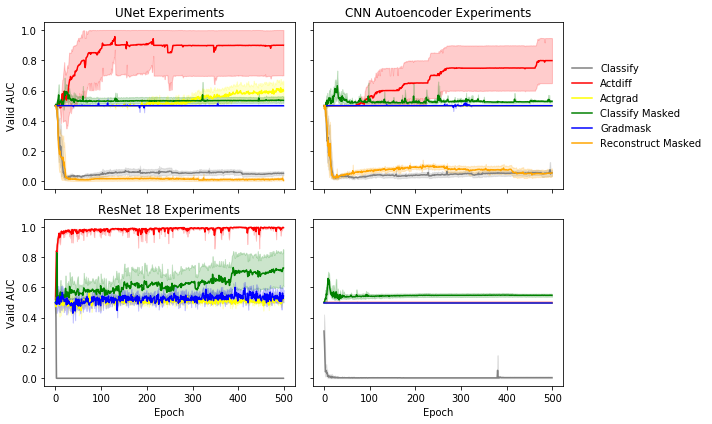

In [17]:
# Plots the Valid AUC over all epochs of the Synthetic Dataset training.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10, 6), 
                                             nrows=2, ncols=2, sharex=True, sharey=True)

palette = {
    'synth_unet': "gray", 
    'synth_unet_actdiff': "red",
    'synth_unet_clfmasked': "green",
    'synth_unet_gradmask': "blue",
    'synth_unet_actgrad': "yellow",
    'synth_unet_reconmasked': "orange"
}

g = sns.lineplot(
    x="epoch", y='valid_auc', hue='experiment_name', 
    ax=ax1, data=get_curveplot_df(df_synth, 'unet'),
    palette=palette, hue_order=sorted(list(palette.keys())))
g.set_title("UNet Experiments")
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.get_legend().remove()
g.set_ylim(-0.05, 1.05)
g.set_xlabel('Epoch')
g.set_ylabel('Valid AUC')

palette = {
    'synth_ae': "gray", 
    'synth_ae_actdiff': "red",
    'synth_ae_clfmasked': "green",
    'synth_ae_gradmask': "blue",
    'synth_ae_actgrad': "yellow",
    'synth_ae_reconmasked': "orange"
}

g = sns.lineplot(
    x="epoch", y='valid_auc', hue='experiment_name', 
    ax=ax2, data=get_curveplot_df(df_synth, 'ae'),
    palette=palette, hue_order=sorted(list(palette.keys())))
g.set_title("CNN Autoencoder Experiments")
g.legend(['Classify', 'Actdiff', 'Actgrad', 'Classify Masked', 'Gradmask', 'Reconstruct Masked'], 
          loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
g.set_ylim(-0.05, 1.05)
g.set_xlabel('Epoch')
g.set_ylabel('Valid AUC')

palette = {
    'synth_resnet': "gray", 
    'synth_resnet_actdiff': "red",
    'synth_resnet_clfmasked': "green",
    'synth_resnet_gradmask': "blue",
    'synth_resnet_actgrad': "yellow"
}

g = sns.lineplot(
    x="epoch", y='valid_auc', hue='experiment_name', 
    ax=ax3, data=get_curveplot_df(df_synth, 'resnet'),
    palette=palette, hue_order=sorted(list(palette.keys())))
g.set_title("ResNet 18 Experiments")
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.get_legend().remove()
g.set_ylim(-0.05, 1.05)
g.set_xlabel('Epoch')
g.set_ylabel('Valid AUC')

palette = {
    'synth_cnn': "gray", 
    'synth_cnn_actdiff': "red",
    'synth_cnn_clfmasked': "green",
    'synth_cnn_gradmask': "blue",
    'synth_cnn_actgrad': "yellow",
}

g = sns.lineplot(
    x="epoch", y='valid_auc', hue='experiment_name', 
    ax=ax4, data=get_curveplot_df(df_synth, 'cnn'),
    palette=palette, hue_order=sorted(list(palette.keys())))
g.set_title("CNN Experiments")
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.get_legend().remove()
g.set_ylim(-0.05, 1.05)
g.set_xlabel('Epoch')
g.set_ylabel('Valid AUC')

fig.set_tight_layout(tight=True)

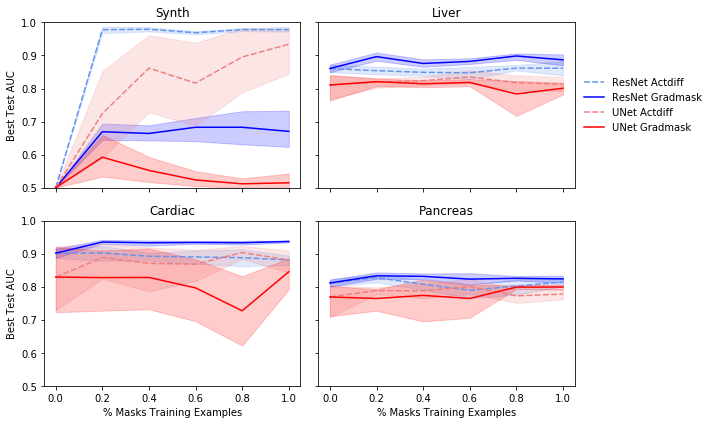

In [14]:
# Gets the best test auc (early stopping) for all masks experiments.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10, 6), 
                                             nrows=2, ncols=2, sharex=True, sharey=True)

palette = {
    'synth-masks_unet_gradmask': "red", 
    'synth-masks_unet_actdiff': "lightcoral",
    'synth-masks_resnet_gradmask': "blue",
    'synth-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_test_auc', hue='experiment_name', 
    ax=ax1, data=get_lineplot_df(df_synth_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Synth")
g.set(ylim=(0.5, 1.05))
g.get_legend().remove()
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Test AUC')

palette = {
    'livermsd-masks_unet_gradmask': "red", 
    'livermsd-masks_unet_actdiff': "lightcoral",
    'livermsd-masks_resnet_gradmask': "blue",
    'livermsd-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_test_auc', hue='experiment_name', 
    ax=ax2, data=get_lineplot_df(df_liver_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Liver")
g.set(ylim=(0.5, 1.0))
g.legend(['ResNet Actdiff', 'ResNet Gradmask', 'UNet Actdiff', 'UNet Gradmask'], 
         loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Test AUC')


palette = {
    'cardiacmsd-masks_unet_gradmask': "red", 
    'cardiacmsd-masks_unet_actdiff': "lightcoral",
    'cardiacmsd-masks_resnet_gradmask': "blue",
    'cardiacmsd-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_test_auc', hue='experiment_name', 
    ax=ax3, data=get_lineplot_df(df_cardiac_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Cardiac")
g.set(ylim=(0.5, 1.0))
g.get_legend().remove()
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Test AUC')


palette = {
    'pancreasmsd-masks_unet_gradmask': "red", 
    'pancreasmsd-masks_unet_actdiff': "lightcoral",
    'pancreasmsd-masks_resnet_gradmask': "blue",
    'pancreasmsd-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_test_auc', hue='experiment_name', 
    ax=ax4, data=get_lineplot_df(df_pancreas_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Pancreas")
g.set(ylim=(0.5, 1.0))
g.get_legend().remove()
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Test AUC')



fig.set_tight_layout(tight=True)

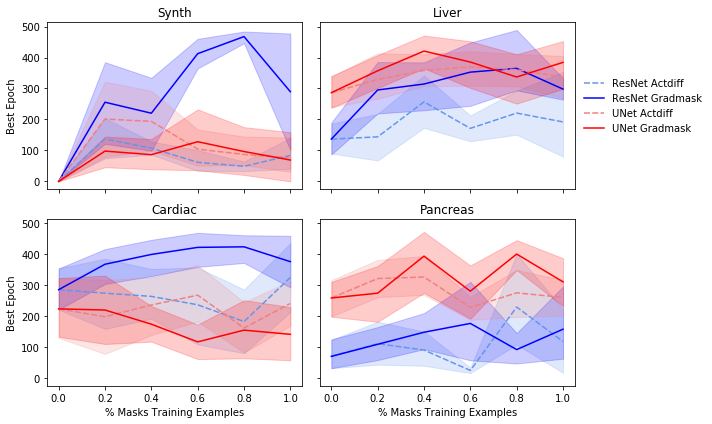

In [16]:
# Gets the best epoch (early stopping) for all masks experiments.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10, 6), 
                                             nrows=2, ncols=2, sharex=True, sharey=True)

palette = {
    'synth-masks_unet_gradmask': "red", 
    'synth-masks_unet_actdiff': "lightcoral",
    'synth-masks_resnet_gradmask': "blue",
    'synth-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_epoch', hue='experiment_name', 
    ax=ax1, data=get_lineplot_df(df_synth_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Synth")
g.get_legend().remove()
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Epoch')


palette = {
    'livermsd-masks_unet_gradmask': "red", 
    'livermsd-masks_unet_actdiff': "lightcoral",
    'livermsd-masks_resnet_gradmask': "blue",
    'livermsd-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_epoch', hue='experiment_name', 
    ax=ax2, data=get_lineplot_df(df_liver_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Liver")
g.legend(['ResNet Actdiff', 'ResNet Gradmask', 'UNet Actdiff', 'UNet Gradmask'],
          loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Epoch')


palette = {
    'cardiacmsd-masks_unet_gradmask': "red", 
    'cardiacmsd-masks_unet_actdiff': "lightcoral",
    'cardiacmsd-masks_resnet_gradmask': "blue",
    'cardiacmsd-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_epoch', hue='experiment_name', 
    ax=ax3, data=get_lineplot_df(df_cardiac_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Cardiac")
g.get_legend().remove()
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Epoch')


palette = {
    'pancreasmsd-masks_unet_gradmask': "red", 
    'pancreasmsd-masks_unet_actdiff': "lightcoral",
    'pancreasmsd-masks_resnet_gradmask': "blue",
    'pancreasmsd-masks_resnet_actdiff': "cornflowerblue",
}

g = sns.lineplot(
    x="maxmasks_train", y='best_epoch', hue='experiment_name', 
    ax=ax4, data=get_lineplot_df(df_pancreas_mask, EPOCH),
    palette=palette, style='actdiff_lambda', hue_order=sorted(list(palette.keys())))
g.set_title("Pancreas")
g.get_legend().remove()
g.set_xlabel('% Masks Training Examples')
g.set_ylabel('Best Epoch')

fig.set_tight_layout(tight=True)